In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import glob, re

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../../src')
from m3_learning.RHEED.Analysis_umich import plot_activation_energy, select_range
from m3_learning.RHEED.Analysis import detect_peaks, process_rheed_data, process_curves
from m3_learning.RHEED.Fitting import fit_exp_function, normalize_and_extract_amplitude, de_normalize_and_assemble, fit_curves
from m3_learning.viz.layout import layout_fig
from m3_learning.RHEED.Viz import Viz

In [2]:
expo_time = 20
camera_freq = 1000/expo_time
laser_freq = 2

denoise_params = {'savgol_window_order': (3, 2), 'pca_component': 2, 'fft_cutoff_order':None, 'median_kernel_size':None}
curve_params = {'trim_first':0, 'tune_tail':False, 'convolve_step':5, 'prominence':10, 'mode':'valid', 'linear_ratio':0.8}
# normalize_params = {'I_diff': None, 'unify':False, 'bounds':[0.2, 20], 'p_init':(15, 5), 'n_std':3}
normalize_params = {'I_diff': None, 'unify':False, 'bounds':None, 'p_init':None, 'n_std':3}
viz_params = {'viz_denoise': True, 'viz_curves': True, 'viz_fittings': True, 'viz_ab': False}


(80715, 4)


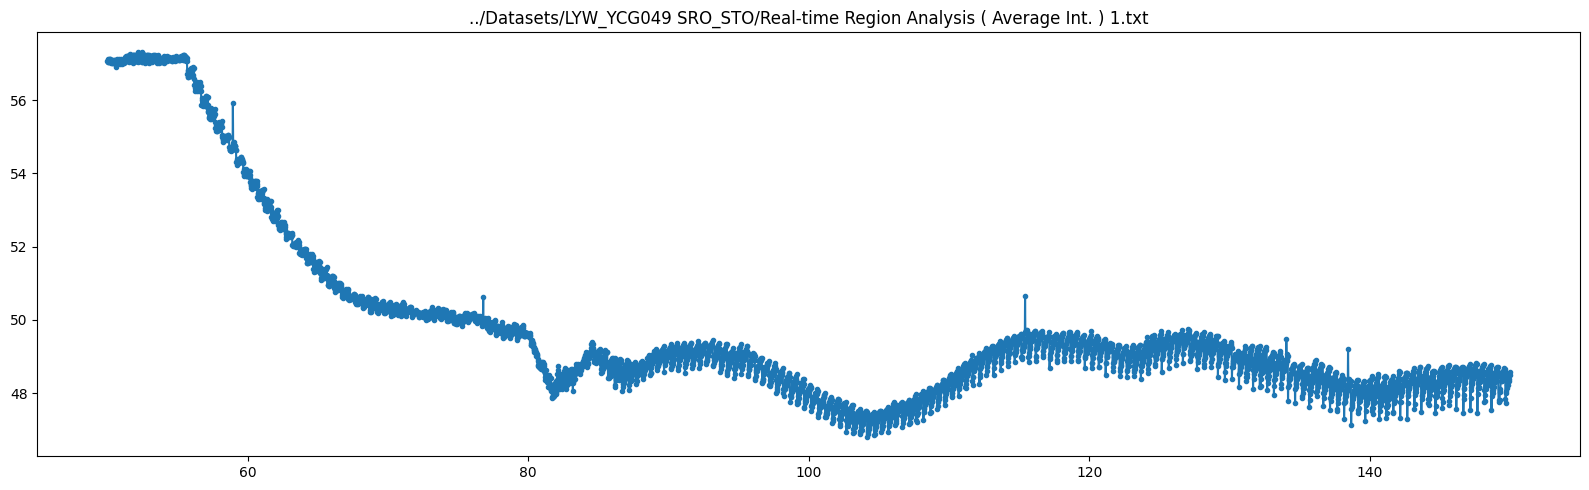

In [3]:
file = '../Datasets/LYW_YCG049 SRO_STO/Real-time Region Analysis ( Average Int. ) 1.txt'
data = np.loadtxt(file)
print(data.shape)
data = select_range(data, 50, 150, y_col=2)
plt.subplots(1, 1, figsize=(16,5))
plt.plot(data[:,0], data[:,1], marker='o', markersize=3)
plt.title(file)
plt.tight_layout()
plt.show()

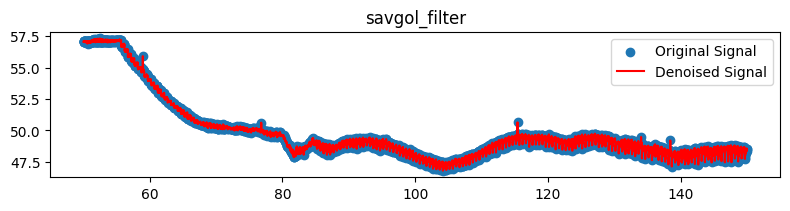

(4960,) (4960,)


In [4]:
denoise_params = {'savgol_window_order': (3, 2), 'pca_component': None, 'fft_cutoff_order':None, 'median_kernel_size':None}

if isinstance(data, str):
    data = np.loadtxt(data)
sample_x, sample_y = data[:,0], data[:,1]

# denoise
sample_x, sample_y = process_rheed_data(sample_x, sample_y, camera_freq, denoise_params, viz_params['viz_denoise'])  
print(sample_x.shape, sample_y.shape)    

200 200


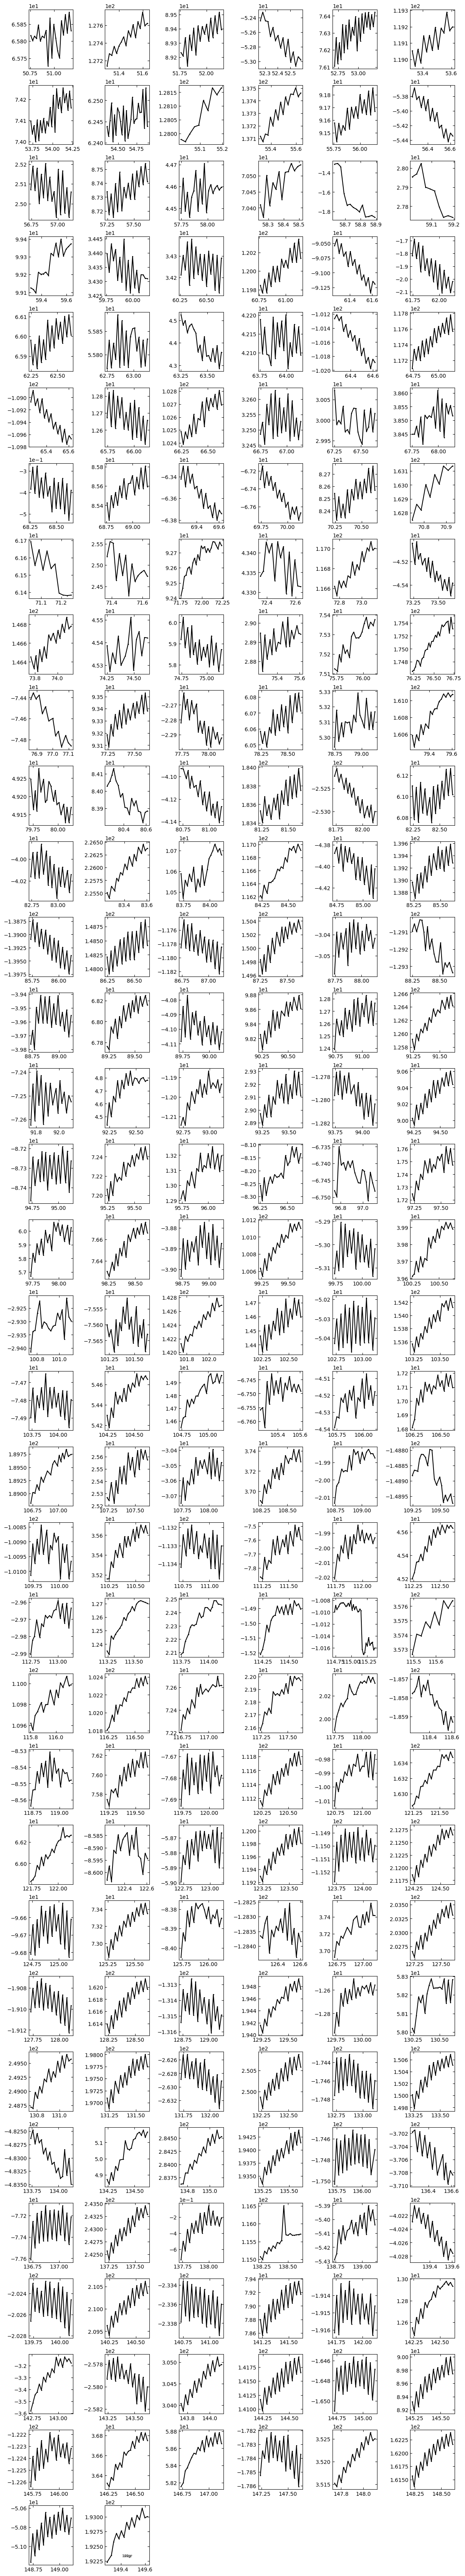

In [5]:
expo_time = 20
camera_freq = 1000/expo_time
laser_freq = 2
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':2, 'prominence':0.1, 'mode':'valid', 'linear_ratio':0.3}

# detect peaks
# print(sample_y[0].shape, sample_y[1].shape)
x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=laser_freq, curve_params=curve_params)

# denoise
xs, ys = process_curves(xs, ys, curve_params)     
print(len(xs), len(ys))  

# viz curves
if viz_params['viz_curves']:
    xs_sample, ys_sample = xs[::1], ys[::1]
    fig, axes = layout_fig(len(ys_sample), mod=6, figsize=(12,2*len(ys_sample)//6+1), layout='compressed')
    Viz.show_grid_plots(axes, xs_sample, ys_sample, labels=None, xlabel=None, ylabel=None, ylim=None, legend=None, color=None)

In [45]:
fit_settings = {'I_diff': None, 'unify': True, 'bounds': [0.01, 1], 'p_init': (1, 0.1, 0.4), 'n_std': 1}
growth_name='YG049'


I_diff = fit_settings['I_diff']
unify = fit_settings['unify']

# Step 1: Normalize and extract amplitude
ys_nor, I_starts, I_ends = normalize_and_extract_amplitude(xs, ys, I_diff, unify)

# Step 2: Fit curves
parameters, ys_nor_fit, ys_nor_fit_failed, labels, losses = fit_curves(xs, ys_nor, fit_settings, growth_name)

# Step 3: De-normalize and assemble results
ys_fit = de_normalize_and_assemble(xs, ys, ys_nor_fit, I_starts, I_ends, I_diff, unify)

parameters = np.array(parameters)
metadata = [xs, ys, ys_fit, ys_nor, ys_nor_fit, ys_nor_fit_failed, labels, losses]

# parameters, metadata = fit_exp_function(xs, ys, growth_name='YG049', fit_settings=fit_settings)
a, b, tau = parameters[:,0], parameters[:,1], parameters[:,2]
[xs, ys, ys_fit, ys_nor, ys_nor_fit, ys_nor_fit_failed, labels, losses] = metadata
x_coors = x_peaks[:-1]

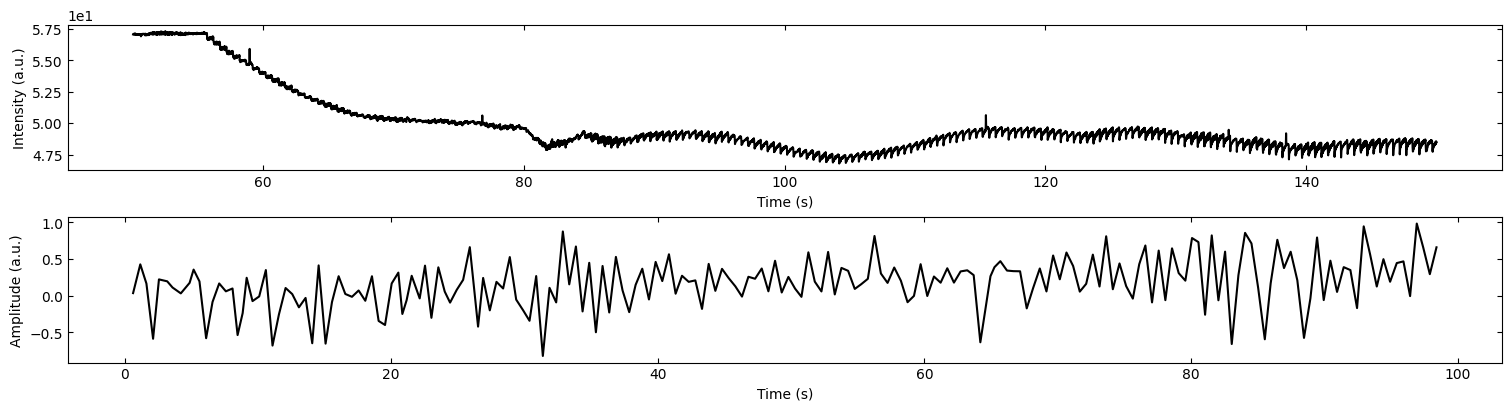

In [46]:
I_starts, I_ends = np.array(I_starts), np.array(I_ends)
I_diff = I_ends - I_starts

fig, axes = layout_fig(2, 1, figsize=(15, 2*2))
Viz.plot_curve(axes[0], sample_x, sample_y, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity (a.u.)', yaxis_style='sci')
Viz.plot_curve(axes[1], x_coors, I_diff, plot_type='lineplot', xlabel='Time (s)', ylabel='Amplitude (a.u.)', yaxis_style='sci')
plt.show()

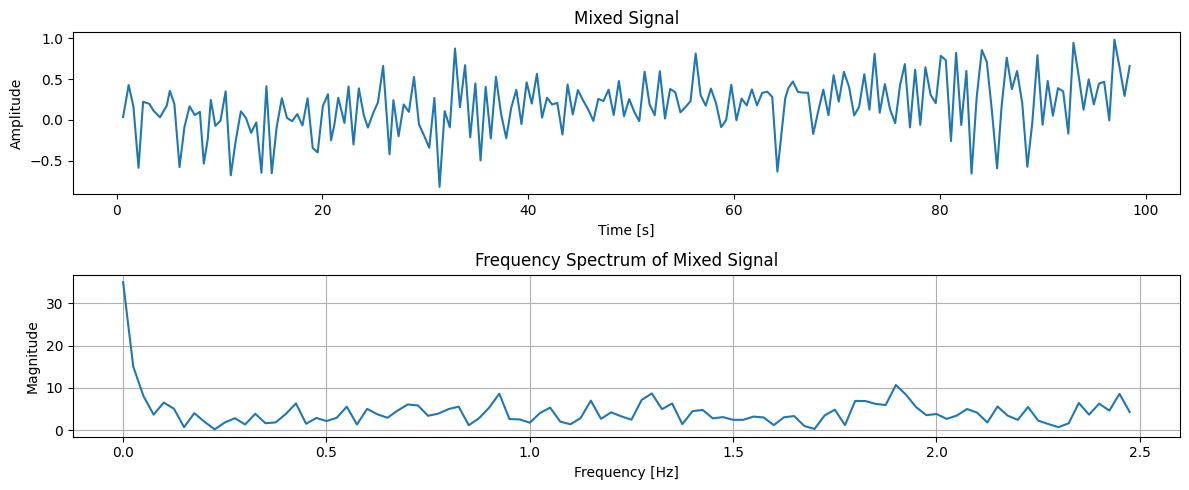

In [51]:
from scipy.fftpack import fft, ifft

# Generate synthetic mixed signals
fs = 5  # Sampling frequency

t = x_coors
mixed_signal = I_diff

# Perform FFT
n = len(t)
f = np.fft.fftfreq(n, 1/fs)
mixed_signal_fft = fft(mixed_signal)

# Plot the mixed signal and its frequency spectrum
fig, axes = plt.subplots(2, 1, figsize=(12, 5))
axes[0].plot(t, mixed_signal)
axes[0].set_title('Mixed Signal')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Amplitude')
axes[1].plot(f[:n//2], np.abs(mixed_signal_fft)[:n//2])
axes[1].set_title('Frequency Spectrum of Mixed Signal')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel('Magnitude')
axes[1].grid()
plt.tight_layout()
plt.show()

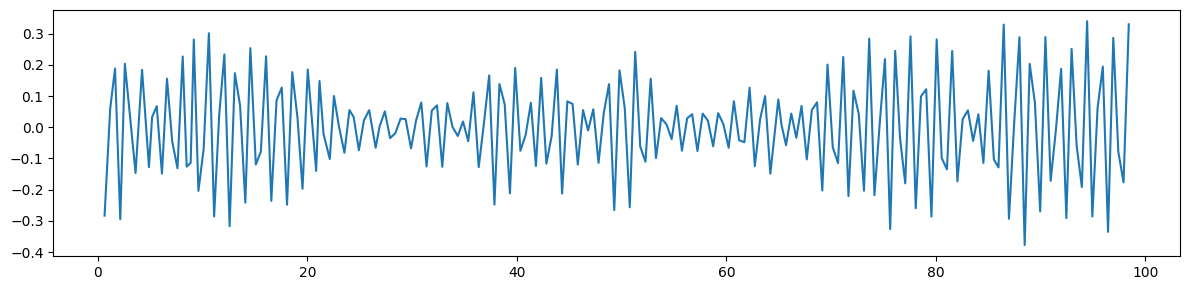

In [52]:
# Filter signals (band-pass filters)
def bandpass_filter(signal_fft, freq, fs, lowcut, highcut):
    f = np.fft.fftfreq(len(signal_fft), 1/fs)
    filter_mask = np.logical_and(freq >= lowcut, freq <= highcut)
    filter_mask = np.logical_or(filter_mask, np.logical_and(freq <= -lowcut, freq >= -highcut))
    filtered_fft = signal_fft * filter_mask
    return ifft(filtered_fft)

# Isolate each frequency component
filtered_signal = bandpass_filter(mixed_signal_fft, f, fs, 1.5, 2)

# Plot isolated signals
plt.figure(figsize=(12, 3))
plt.plot(t, filtered_signal.real)
plt.tight_layout()
plt.show()

In [7]:
print(sample_x.shape, sample_y.shape, x_coors.shape, a.shape, b.shape, tau.shape)

(4960,) (4960,) (200,) (200,) (200,) (200,)


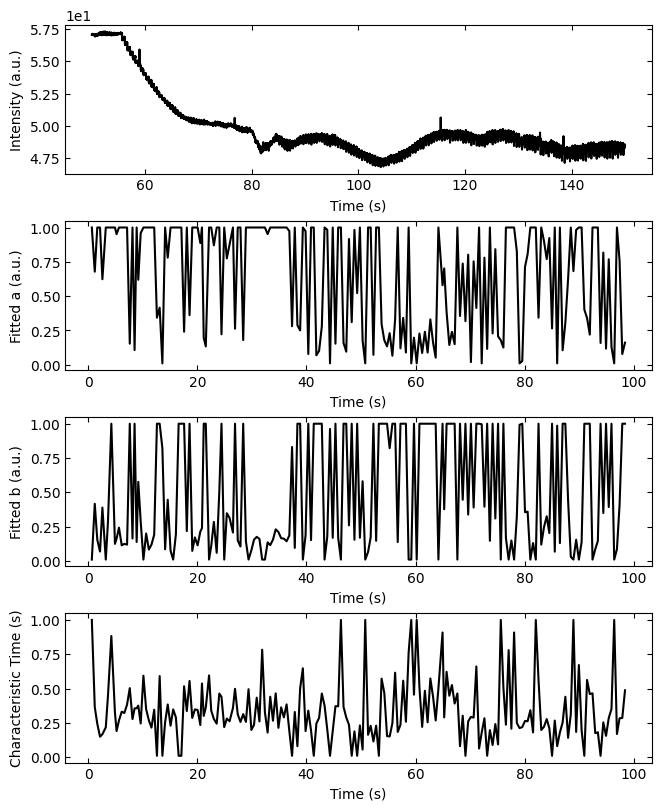

In [8]:
fig, axes = layout_fig(4, 1, figsize=(6.5, 2*4))
Viz.plot_curve(axes[0], sample_x, sample_y, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity (a.u.)', yaxis_style='sci')
Viz.plot_curve(axes[1], x_coors, a, plot_type='lineplot', xlabel='Time (s)', ylabel='Fitted a (a.u.)')
Viz.plot_curve(axes[2], x_coors, b, plot_type='lineplot', xlabel='Time (s)', ylabel='Fitted b (a.u.)')
Viz.plot_curve(axes[3], x_coors, tau, plot_type='lineplot', xlabel='Time (s)', ylabel='Characteristic Time (s)')
plt.show()

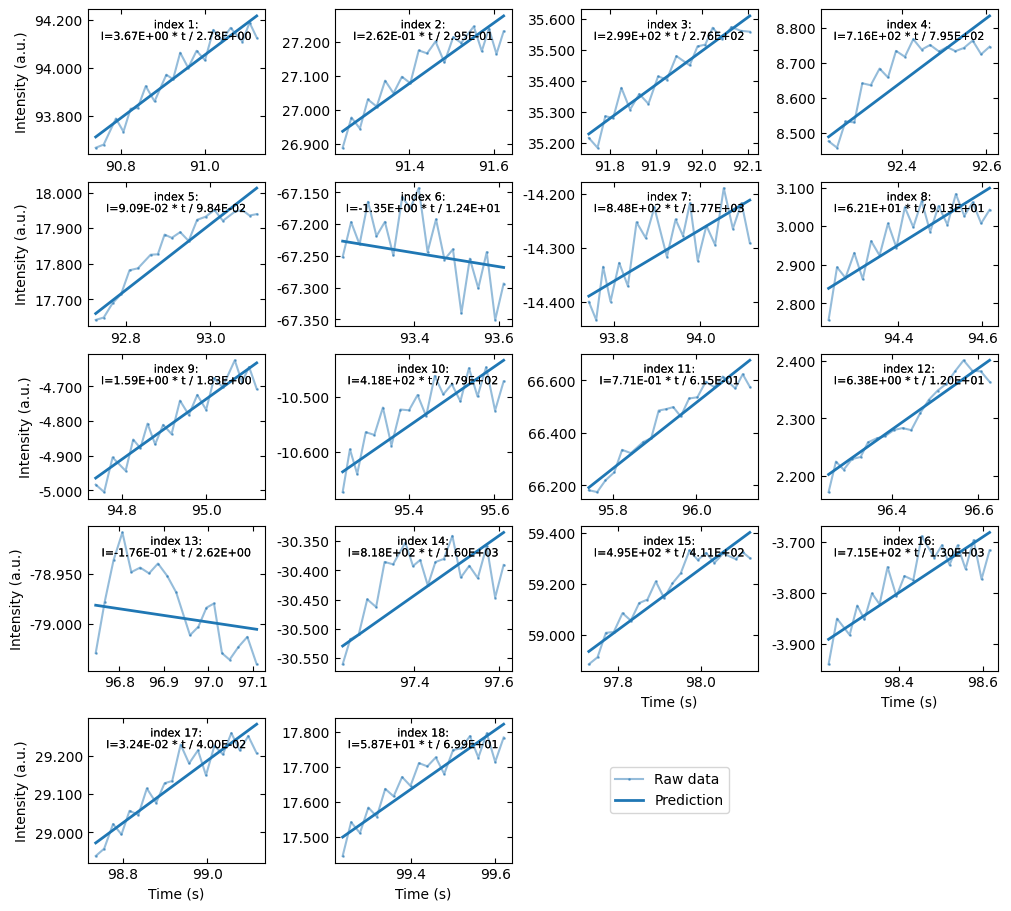

In [121]:
# fit exponential function
b_list, tau_list, ys_fit, labels = fit_tau(xs, ys, normalize_params=normalize_params)

# viz fittings
if viz_params['viz_fittings']:
    Viz.plot_fit_details(xs, ys, ys_fit, y3=None, labels=labels, figsize=(10, 1.8*len(xs)//4+1), mod=4, style='presentation', logscale=False)  

(33037, 4)


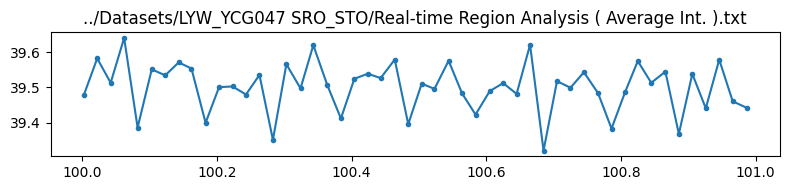

In [13]:
file = '../Datasets/LYW_YCG047 SRO_STO/Real-time Region Analysis ( Average Int. ).txt'
data = np.loadtxt(file)
print(data.shape)

data = select_range(data, 100, 101, y_col=3)

plt.subplots(1, 1, figsize=(8,2))
plt.plot(data[:,0], data[:,1], marker='o', markersize=3)
plt.title(file)
plt.tight_layout()
plt.show()

(59820, 4)


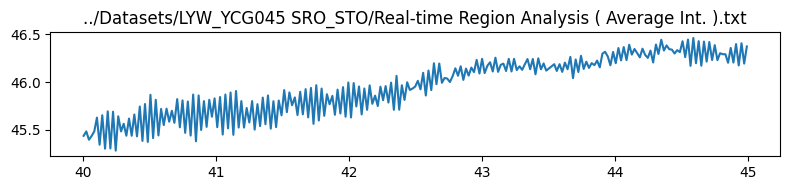

In [6]:
file = '../Datasets/LYW_YCG045 SRO_STO/Real-time Region Analysis ( Average Int. ).txt'
data = np.loadtxt(file)
print(data.shape)

data = select_range(data, 40, 45, y_col=3)

plt.subplots(1, 1, figsize=(8,2))
plt.plot(data[:,0], data[:,1])
plt.title(file)
plt.tight_layout()
plt.show()

In [10]:
file = '../Datasets/LYW_YCG046 SRO_STO/Real-time Region Analysis ( Average Int. ).txt'
data = np.loadtxt(file)
print(data.shape)

(42895, 4)


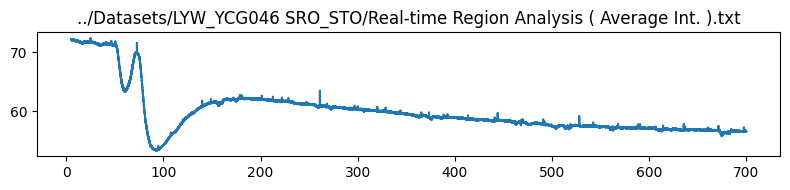

In [11]:
data_ = select_range(data, 0, 700, y_col=1)
plt.subplots(1, 1, figsize=(8,2))
plt.plot(data_[:,0], data_[:,1])
plt.title(file)
plt.tight_layout()
plt.show()

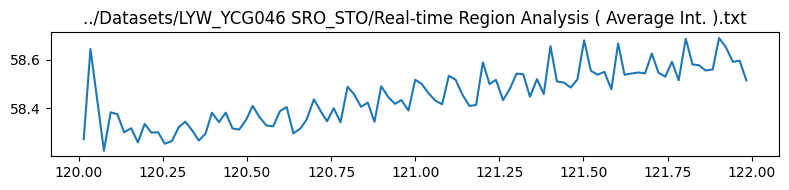

In [7]:
data_ = select_range(data, 120, 122, y_col=1)
plt.subplots(1, 1, figsize=(8,2))
plt.plot(data_[:,0], data_[:,1])
plt.title(file)
plt.tight_layout()
plt.show()

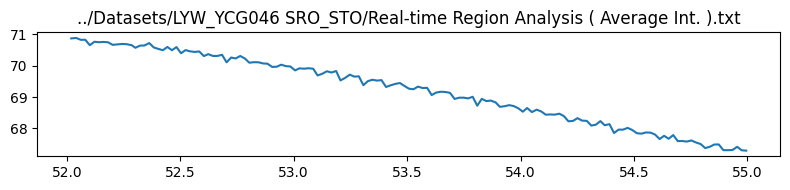

In [38]:
data_ = select_range(data, 52, 55, y_col=1)
plt.subplots(1, 1, figsize=(8,2))
plt.plot(data_[:,0], data_[:,1])
plt.title(file)
plt.tight_layout()
plt.show()

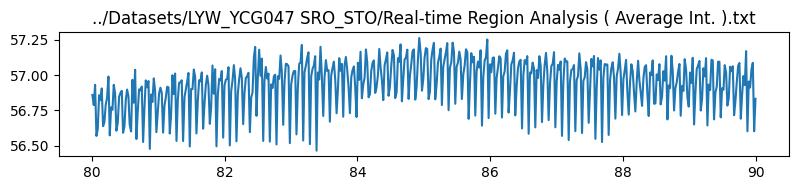

In [19]:
file = '../Datasets/LYW_YCG047 SRO_STO/Real-time Region Analysis ( Average Int. ).txt'
data = np.loadtxt(file)

data_ = select_range(data, 80, 90, y_col=2)
plt.subplots(1, 1, figsize=(8,2))
plt.plot(data_[:,0], data_[:,1])
plt.title(file)
plt.tight_layout()
plt.show()

In [ ]:
expo_time = 50
camera_freq = 1000/expo_time
laser_freq = 10

denoise_params = {'savgol_window_order': (3, 2), 'pca_component': None, 'fft_cutoff_order':None, 'median_kernel_size':None}
curve_params = {'trim_first':0, 'tune_tail':False, 'convolve_step':5, 'prominence':10, 'mode':'valid', 'linear_ratio':0.8}
# normalize_params = {'I_diff': None, 'unify':False, 'bounds':[0.2, 20], 'p_init':(15, 5), 'n_std':3}
normalize_params = {'I_diff': None, 'unify':False, 'bounds':None, 'p_init':None, 'n_std':3}
viz_params = {'viz_denoise': True, 'viz_curves': True, 'viz_fittings': True, 'viz_ab': False}

b_list, tau_list, ys_fit, labels = analyze_rheed_data_txt(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)  